In [2]:
import rich

import pandas
import seaborn

import cltrier_lib

In [3]:
DATA_PATH: str = "../../data/raw/twitter"
REPORT_PATH: str = "../../reports/preliminary"

In [4]:
datasets = {
    ("German", "Posts"): pandas.read_csv(f"{DATA_PATH}.german/GermanyMdBTweets_2023.csv", index_col=[0]),
    ("German", "Replies"): pandas.read_csv(f"{DATA_PATH}.german/GermanyReplies2023.csv", index_col=[0]),
    ("English", "Posts"): pandas.read_csv(f"{DATA_PATH}.english/USCongressTweets_2023.csv"),
    ("English", "Replies"): pandas.concat(
        [
            pandas.read_csv(f"{DATA_PATH}.english/{split}.csv")
            for split in [
                "USReplies_2023_1", "USReplies_2023_2", "USReplies_2023_July",
                "USReplies_2023_August_I", "USReplies_2023_August_II"
            ]
        ]
)
}

/tmp/ipykernel_3551473/445495506.py:7: DtypeWarning: Columns (2,3,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  pandas.read_csv(f"{DATA_PATH}.english/{split}.csv")


In [5]:
rich.print({
    label: len(df)
    for label, df in datasets.items()
})

{
    ('German', 'Posts'): 154834,
    ('German', 'Replies'): 3226277,
    ('English', 'Posts'): 932755,
    ('English', 'Replies'): 17803216
}

In [6]:
for df in datasets.values():
    rich.print(df.columns)

Index(['id', 'author_id', 'conversation_id', 'text',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.impression_count', 'public_metrics.bookmark_count',
       'created_at', 'username'],
      dtype='object')

Index(['id', 'author_id', 'conversation_id', 'text',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.bookmark_count', 'public_metrics.impression_count',
       'created_at', 'username', 'in_reply_to_user_id'],
      dtype='object')

Index(['full_text', 'tweet_id', 'created_at', 'screen_name',
       'original_user_id', 'retweeted_user_ID', 'collected_at', 'reply_to_id',
       'reply_to_user', 'expandedURL'],
      dtype='object')

Index(['full_text', 'tweet_id', 'created_at', 'screen_name',
       'original_user_id', 'retweeted_user_ID', 'collected_at', 'reply_to_id',
       'reply_to_user', 'expandedURL'],
      dtype='object')

In [7]:
for label in [
    ("English", "Posts"),
    ("English", "Replies")
]:
    datasets[label] = datasets[label].rename(columns={"full_text": "text", "tweet_id": "id", "original_user_id": "author_id"})

In [8]:
sampled_concated_dataset = (
    pandas.concat(
        [
            df[["author_id", "text"]].sample(100_000)
            for df in datasets.values()
        ],
        keys=datasets.keys()
    )
    .reset_index()
    .rename(columns={"level_0": "lang", "level_1": "subset", "level_2": "idx"})
)
sampled_concated_dataset

,lang,subset,idx,author_id,text
0,German,Posts,83908,3.145347e+08,@moabsla @DeineEVG @dieLinke @Linksfraktion Qu...
1,German,Posts,35657,1.504396e+18,In einer Notsituation hätten wir zumindest die...
2,German,Posts,91157,3.710514e+07,"RT @TiloJung: Liebe Studierende, macht euch ke..."
3,German,Posts,93967,3.960696e+08,RT @Hemiunu2021: Man kann den Grünen D anvertr...
4,German,Posts,38616,1.524342e+18,@schaefer_vgtlnd Immer auf der Flucht vor sein...
...,...,...,...,...,...
399995,English,Replies,3957057,4.937150e+08,@pandorabox82 @MrAndyNgo You sound happy.
399996,English,Replies,6136038,4.834787e+08,Remember when the left fought so hard for wome...
399997,English,Replies,2856471,2.389507e+07,https://t.co/Vq4aIVIpks
399998,English,Replies,3445536,1.873019e+07,"Bucks 'win ugly', survive Bulls rally in Game ..."


In [9]:
(
    sampled_concated_dataset
    .groupby(["lang", "subset"])
    ["author_id"]
    .value_counts()
    .reset_index()
    .groupby(["lang", "subset"])
    ["count"]
    .describe()
    .drop(columns=["count"])
    #.to_latex(float_format="%.2f")
)

mean         std  min   25%    50%    75%     max
lang    subset                                                          
English Posts     98.033126   23.832336  2.0  94.0  105.0  112.0   143.0
        Replies    2.693299    2.589463  1.0   1.0    2.0    3.0    33.0
German  Posts    145.348837  236.904351  1.0  19.0   72.0  166.0  2115.0
        Replies    2.245980    3.167153  1.0   1.0    1.0    2.0   127.0

In [10]:
(
    sampled_concated_dataset
    .pipe(lambda _df: (
        _df
        .assign(text=_df["text"].str.replace('http\S+|www.\S+', '', case=False))
        .assign(text=_df["text"].str.replace('@\S+', '', case=False))
        .assign(text=_df["text"].str.replace('^RT', '', case=True))
        .assign(text_length=_df["text"].str.len())
    ))
    .groupby(["lang", "subset"])
    ["text_length"]
    .describe()
    .drop(columns=["count"])
    #.to_latex(float_format="%.2f")
)

mean        std  min    25%    50%    75%    max
lang    subset                                                        
English Posts    193.81578  84.095559  1.0  127.0  208.0  271.0  879.0
        Replies  139.91395  95.813128  1.0   59.0  116.0  220.0  976.0
German  Posts    164.39766  78.977837  1.0  125.0  140.0  235.0  725.0
        Replies  135.04442  86.418396  6.0   62.0  112.0  199.0  572.0

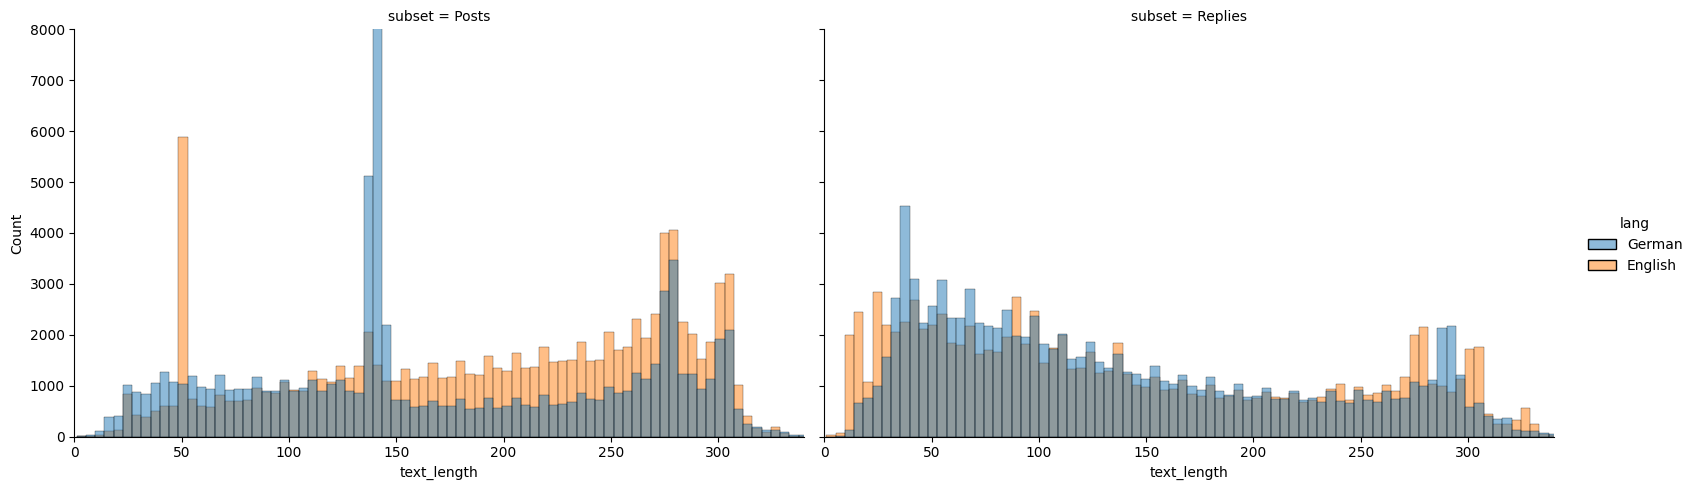

In [11]:
(
    seaborn.displot(
        data=(
            sampled_concated_dataset
            .pipe(lambda _df: (
                _df
                .assign(text=_df["text"].str.replace('http\S+|www.\S+', '', case=False))
                .assign(text=_df["text"].str.replace('@\S+', '', case=False))
                .assign(text_length=_df["text"].str.len())
            ))
        ),
        x="text_length",
        col="subset",
        hue="lang",
        aspect=1.6
    )
    .set(
        xlim=(0, 340), 
        ylim=(0, 8_000)
    )
    .savefig(f"{REPORT_PATH}/dist.len_text.pdf")
)


In [12]:
(
    sampled_concated_dataset
    .pipe(lambda _df: _df.assign(has_url=_df["text"].str.contains("https://")))
    .groupby(["lang", "subset"])
    ["has_url"]
    .value_counts(normalize=True)
    .reset_index(level=2)
    .pipe(lambda _df: _df[_df["has_url"]])
    ["proportion"]
    .to_frame()
    .T
)

lang        English            German         
subset        Posts  Replies    Posts  Replies
proportion  0.69439  0.56522  0.34458  0.18284

In [64]:
classified_dataset = pandas.json_normalize(
    [
        sample.model_dump() | {"lang": label[0], "subset": label[1]}
        for label, group in sampled_concated_dataset.groupby(["lang", "subset"])
        for sample in cltrier_lib.classify.Pipeline()(
            list(group["text"].sample(10_000)), threshold=0.0
        )
    ]
)
classified_dataset

,sample,lang,subset,results.topics.arts_&_culture,results.topics.business_&_entrepreneurs,results.topics.celebrity_&_pop_culture,results.topics.diaries_&_daily_life,results.topics.family,results.topics.fashion_&_style,results.topics.film_tv_&_video,...,results.emotions.trust,results.sentiment.negative,results.sentiment.neutral,results.sentiment.positive,results.irony.non_irony,results.irony.irony,results.offensive.non-offensive,results.offensive.offensive,results.hate.NOT-HATE,results.hate.HATE
0,A record 1.7 million illegal migrants were app...,English,Posts,0.004677,0.008211,0.010753,0.016483,0.002790,0.001163,0.012230,...,0.008827,0.848763,0.595480,0.075005,0.571263,0.509252,0.604379,0.392936,0.914316,0.083051
1,"The WSLC, AFL-CIO is proud to endorse @MGPforC...",English,Posts,0.004962,0.027402,0.008950,0.021075,0.002161,0.001172,0.010280,...,0.346281,0.045110,0.629151,0.914447,0.679416,0.359854,0.813592,0.167602,0.967981,0.038814
2,May the memories of the students and teachers ...,English,Posts,0.012320,0.017031,0.011271,0.099091,0.032299,0.006520,0.010488,...,0.079273,0.319682,0.532467,0.573277,0.796977,0.347525,0.625457,0.373144,0.973225,0.036254
3,Happy Kwanzaa to all those celebrating in Illi...,English,Posts,0.816154,0.013534,0.086329,0.687104,0.802586,0.018426,0.021794,...,0.107095,0.068019,0.293905,0.972565,0.781268,0.313916,0.803764,0.154157,0.975627,0.033421
4,It's the @USNationalGuard's 386th birthday tod...,English,Posts,0.025979,0.011796,0.009431,0.258342,0.011784,0.001286,0.007877,...,0.416811,0.044099,0.514609,0.955862,0.685611,0.446297,0.828887,0.157760,0.972420,0.035758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,"@KonstantinNotz Die Grünen sind doch dafür, da...",German,Replies,0.197259,0.007353,0.025750,0.190359,0.006542,0.002450,0.022645,...,0.029198,0.279909,0.750634,0.390918,0.843489,0.254651,0.679902,0.343243,0.940385,0.070248
39996,@JoanaCotar Hr.Pistorius ist der beste Verteid...,German,Replies,0.034455,0.005758,0.023923,0.111135,0.003174,0.001120,0.008230,...,0.031623,0.233034,0.738598,0.465463,0.845063,0.249077,0.682393,0.328446,0.943886,0.059701
39997,@SWagenknecht Arme Sau.,German,Replies,0.047333,0.016763,0.008593,0.448316,0.003609,0.004658,0.008895,...,0.008916,0.256493,0.802335,0.324580,0.775253,0.343788,0.737054,0.281865,0.919653,0.076379
39998,"@StBrandner Passt nicht in das Weltbild eines,...",German,Replies,0.145532,0.011097,0.037736,0.067296,0.004711,0.003851,0.039694,...,0.005518,0.836819,0.456502,0.118588,0.540561,0.576855,0.616762,0.399366,0.145905,0.794499


In [65]:
(
    classified_dataset
    .filter(regex=r"lang|subset|topics")
    .melt(id_vars=["lang", "subset"])
    .replace(to_replace=r"results\.topics\.", value="", regex=True)
    .rename(columns={"variable": "topic", "value": "prediction"})
    .groupby(["lang", "subset", "topic"])
    ["prediction"]
    .describe()
    .drop(columns=["count"])
)

mean       std       min  \
lang    subset  topic                                                    
English Posts   arts_&_culture            0.034282  0.098270  0.001536   
                business_&_entrepreneurs  0.123182  0.239764  0.001718   
                celebrity_&_pop_culture   0.031410  0.080323  0.002544   
                diaries_&_daily_life      0.113267  0.171097  0.007330   
                family                    0.027629  0.099064  0.000939   
...                                            ...       ...       ...   
German  Replies relationships             0.010374  0.018935  0.000799   
                science_&_technology      0.009121  0.044330  0.000631   
                sports                    0.039086  0.148433  0.000543   
                travel_&_adventure        0.007829  0.027587  0.000827   
                youth_&_student_life      0.003522  0.021261  0.000480   

                                               25%       50%       75%  \
lang    subset  topic                                                    
English Posts   arts_&_culture            0.004554  0.007919  0.020844   
                business_&_entrepreneurs  0.008372  0.016293  0.093639   
                celebrity_&_pop_culture   0.010520  0.014549  0.024604   
                diaries_&_daily_life      0.025189  0.042121  0.110503   
                family                    0.002121  0.003999  0.011494   
...                                            ...       ...       ...   
German  Replies relationships             0.003366  0.006083  0.010987   
                science_&_technology      0.001907  0.002541  0.003976   
                sports                    0.002997  0.004841  0.009711   
                travel_&_adventure        0.002248  0.003434  0.006026   
                youth_&_student_life      0.001213  0.001535  0.002112   

                                               max  
lang    subset  topic                               
English Posts   arts_&_culture            0.935900  
                business_&_entrepreneurs  0.977361  
                celebrity_&_pop_culture   0.980534  
                diaries_&_daily_life      0.963123  
                family                    0.954211  
...                                            ...  
German  Replies relationships             0.560831  
                science_&_technology      0.922084  
                sports                    0.996664  
                travel_&_adventure        0.871864  
                youth_&_student_life      0.813493  

[76 rows x 7 columns]

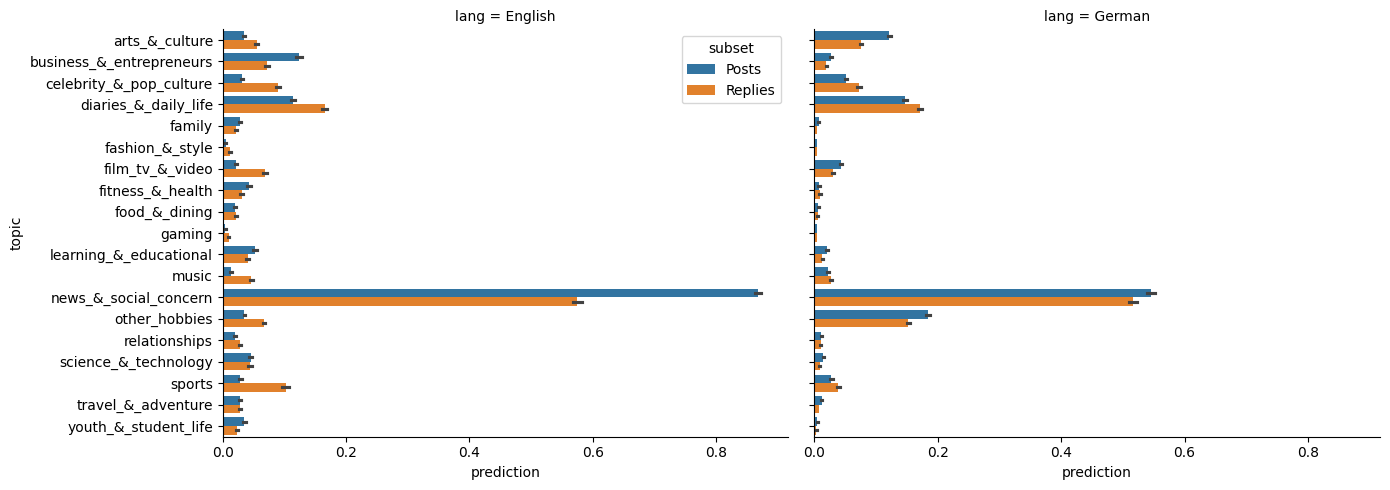

In [68]:
(
    seaborn.catplot(
        kind="bar",
        data=(
            classified_dataset
            .filter(regex=r"lang|subset|topics")
            .melt(id_vars=["lang", "subset"])
            .replace(to_replace=r"results\.topics\.", value="", regex=True)
            .rename(columns={"variable": "topic", "value": "prediction"})
        ),
        y="topic", 
        x="prediction",
        col="lang",
        hue="subset",
        aspect=1.4,
        legend_out=False
    )
    .savefig(f"{REPORT_PATH}/cat.predicted_topic.pdf")
)